## MODELING

### Boosting Models: CatBoost

Haremos 2 aproximaciones: 

- Modelo 1:  CatBoostRegressor con todas las variables del dataset sin seleccionar variables importantes, sin tratar outliers y sin escalar las variables numéricas.

- Modelo 2: CatBoostRegressor seleccionando las variables más importantes (mediante técnicas como PCA, Análisis de Correlación, Información Mutua, ANOVA y ExtraTreesRegressor), tratando outliers (método IQR) y escalando las variables numéricas (MinMaxScaler). El dataset va a ser el mismo que el dataset del modelo 3 de Bagging y Random Forest, pero sin codificar las variables categóricas. 

In [ ]:
def generate_train_test_sets(df_train: pd.DataFrame, 
                             df_test: pd.DataFrame, 
                             target: str) -> Tuple[pd.DataFrame, pd.Series, pd.DataFrame, pd.Series]:
        """
            Generate training and test sets.

            Args:
                df_train (pd.DataFrame): Training dataset.
                df_test (pd.DataFrame): Test dataset.
                target (str): Target variable name.

            Returns:
                X_train (pd.DataFrame): Training features.
                y_train (pd.Series): Training target variable.
                X_test (pd.DataFrame): Test features.
                y_test (pd.Series): Test target variable.
        """
        X_train = df_train.drop(columns=[target])
        y_train = df_train[target]

        X_test = df_test.drop(columns=[target])
        y_test = df_test[target]

        return X_train, y_train, X_test, y_test

#### Modelo 1

- Dataset con mínimo preprocesado. 
- Solo eliminamos las variables que seguro que no son predictoras (id, currency, etc.)
- Convertimos las variables que realmente sean categóricas a 'category' y los valores nulos de las categóricas a 'Unknown'. 

Cargamos los datasets de train y test originales, sin procesar: 

In [ ]:
# cargamos el dataset de train original
train_data_original = pd.read_csv('train_data.csv', delimiter = ',')
# convertimos object a category
train_data_original = convert_object_to_category(train_data_original)
# cargamos el dataset de test original
test_data_original = pd.read_csv('test_data.csv', delimiter=',')
# convertimos object a category
test_data_original = convert_object_to_category(test_data_original)

# exploración rápida del df
print("TRAIN: ")
explore_data(train_data_original)
print("\n\n")
print("TEST: ")
explore_data(test_data_original)

TRAIN: 
The dataset includes 4677 instances (rows) and 33 variables (columns).



,id,price,currency,latitude,longitude,sq_meters,sq_meters_built,rooms,bathrooms,balcony,terrace,exterior,orientation,floor,rooftop,elevator,doorman,pool,ac,heating,year_built,quality,city,neighborhood,dist_city_center,furniture,garage,property_type,garden,closest_station,dist_closest_station,created_at,last_seen
0,85122800,2290000,€,41.409071,2.099850,383.0,532,5,6,1.0,1.0,NaN,sur,4.0,NaN,NaN,NaN,1.0,1.0,individual,2002.0,2,Barcelona,Vallvidrera - El Tibidabo i les Planes,6.302847,NaN,1.0,chalet_independiente,1.0,Zona Universitària,2.949904,8/28/2021 22:42,8/29/2021 17:23
1,95206437,90000,€,41.434545,2.171110,42.0,50,1,1,NaN,NaN,1.0,norte,NaN,NaN,1.0,NaN,NaN,1.0,bomba,1960.0,2,Barcelona,Can Peguera - El Turó de la Peira,5.189265,NaN,NaN,piso,NaN,Llucmajor,0.329115,10/3/2021 22:52,11/12/2021 16:40
2,94361131,145000,€,41.444518,2.175309,NaN,53,3,1,1.0,NaN,1.0,NaN,2.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,2,Barcelona,Verdun,6.313668,NaN,NaN,piso,NaN,Via Júlia,0.284071,9/3/2021 10:47,10/23/2021 22:21
3,95156089,675000,€,41.392209,2.153368,93.0,120,4,2,NaN,1.0,NaN,norte,NaN,1.0,1.0,NaN,NaN,1.0,individual,1967.0,2,Barcelona,L'Antiga Esquerra de l'Eixample,1.462060,NaN,NaN,atico,NaN,Hospital Clínic,0.443717,9/2/2021 13:50,9/2/2021 13:50
4,94994259,319000,€,41.413385,2.162246,NaN,69,3,1,NaN,NaN,1.0,NaN,8.0,1.0,1.0,NaN,NaN,NaN,NaN,1952.0,2,Barcelona,El Baix Guinardó,2.906147,NaN,NaN,piso,NaN,Alfons X,0.371854,8/30/2021 12:17,8/30/2021 12:17




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4677 entries, 0 to 4676
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   id                    4677 non-null   int64   
 1   price                 4677 non-null   int64   
 2   currency              4677 non-null   category
 3   latitude              4677 non-null   float64 
 4   longitude             4677 non-null   float64 
 5   sq_meters             2589 non-null   float64 
 6   sq_meters_built       4677 non-null   int64   
 7   rooms                 4677 non-null   int64   
 8   bathrooms             4677 non-null   int64   
 9   balcony               1759 non-null   float64 
 10  terrace               1121 non-null   float64 
 11  exterior              3803 non-null   float64 
 12  orientation           2524 non-null   category
 13  floor                 2997 non-null   float64 
 14  rooftop               324 non-null    float64 
 15  el

,id,price,latitude,longitude,sq_meters,sq_meters_built,rooms,bathrooms,balcony,terrace,exterior,floor,rooftop,elevator,doorman,pool,ac,year_built,quality,dist_city_center,furniture,garage,garden,dist_closest_station
count,4.677000e+03,4.677000e+03,4677.000000,4677.000000,2589.000000,4677.000000,4677.000000,4677.000000,1759.0,1121.0,3803.000000,2997.000000,324.0,4207.000000,0.0,124.0,2108.0,3262.000000,4677.0,4677.000000,0.0,322.0,50.0,4677.000000
mean,9.351317e+07,3.581391e+05,41.406605,2.168259,70.815759,86.017746,2.581997,1.411375,1.0,1.0,0.868788,3.184518,1.0,0.625862,NaN,1.0,1.0,1954.382281,2.0,3.502737,NaN,1.0,1.0,0.360227
std,6.171778e+06,4.965949e+05,0.026132,0.022778,48.171348,67.622299,1.161822,0.794350,0.0,0.0,0.337677,2.267269,0.0,0.483957,NaN,0.0,0.0,36.387571,0.0,2.034107,NaN,0.0,0.0,0.283624
min,3.202940e+05,2.800000e+04,41.355002,2.092727,3.000000,13.000000,0.000000,1.000000,1.0,1.0,0.000000,1.000000,1.0,0.000000,NaN,1.0,1.0,1777.000000,2.0,0.075001,NaN,1.0,1.0,0.003595
25%,9.379396e+07,1.350000e+05,41.382507,2.153542,48.000000,55.000000,2.000000,1.000000,1.0,1.0,1.000000,1.000000,1.0,0.000000,NaN,1.0,1.0,1940.000000,2.0,1.749035,NaN,1.0,1.0,0.212806
50%,9.498449e+07,1.870000e+05,41.404373,2.170357,60.000000,68.000000,3.000000,1.000000,1.0,1.0,1.000000,3.000000,1.0,1.000000,NaN,1.0,1.0,1964.000000,2.0,3.361964,NaN,1.0,1.0,0.311484
75%,9.513342e+07,3.900000e+05,41.424723,2.180815,78.000000,92.000000,3.000000,2.000000,1.0,1.0,1.000000,4.000000,1.0,1.000000,NaN,1.0,1.0,1972.000000,2.0,4.915237,NaN,1.0,1.0,0.421032
max,9.589391e+07,9.500000e+06,41.465303,2.220785,689.000000,970.000000,11.000000,9.000000,1.0,1.0,1.000000,25.000000,1.0,1.000000,NaN,1.0,1.0,2021.000000,2.0,8.627149,NaN,1.0,1.0,4.203571



 Number of duplicates: 0



TEST: 
The dataset includes 1170 instances (rows) and 33 variables (columns).



,id,price,currency,latitude,longitude,sq_meters,sq_meters_built,rooms,bathrooms,balcony,terrace,exterior,orientation,floor,rooftop,elevator,doorman,pool,ac,heating,year_built,quality,city,neighborhood,dist_city_center,furniture,garage,property_type,garden,closest_station,dist_closest_station,created_at,last_seen
0,95316373,133000,€,41.421077,2.213120,60.0,76,3,1,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,gas,1963.0,2,Barcelona,Sant Martí,5.158288,NaN,NaN,piso,NaN,Besòs,0.272653,10/4/2021 3:57,10/4/2021 15:23
1,95030254,485000,€,41.380788,2.152472,126.0,130,4,2,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1950.0,2,Barcelona,La Nova Esquerra de l'Eixample,1.657143,NaN,NaN,piso,NaN,Rocafort,0.245719,8/30/2021 10:35,9/1/2021 13:38
2,95120234,265000,€,41.406803,2.183533,70.0,77,3,1,NaN,NaN,1.0,norte,5.0,NaN,1.0,NaN,NaN,1.0,NaN,1961.0,2,Barcelona,El Camp de l'Arpa del Clot,2.389801,NaN,NaN,piso,NaN,Encants,0.084520,8/30/2021 14:27,9/1/2021 18:42
3,95655112,154500,€,41.433890,2.172277,NaN,61,2,1,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,gas,1958.0,2,Barcelona,Porta,5.119194,NaN,NaN,piso,NaN,Llucmajor,0.355555,10/22/2021 16:13,10/22/2021 16:13
4,91626733,1200000,€,41.393411,2.145017,NaN,120,3,2,NaN,NaN,1.0,sur,2.0,NaN,1.0,NaN,NaN,1.0,gas,1936.0,2,Barcelona,Sant Gervasi - Galvany,2.166588,NaN,NaN,piso,NaN,Hospital Clínic,0.735841,8/28/2021 20:59,8/29/2021 14:06




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1170 entries, 0 to 1169
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   id                    1170 non-null   int64   
 1   price                 1170 non-null   int64   
 2   currency              1170 non-null   category
 3   latitude              1170 non-null   float64 
 4   longitude             1170 non-null   float64 
 5   sq_meters             685 non-null    float64 
 6   sq_meters_built       1170 non-null   int64   
 7   rooms                 1170 non-null   int64   
 8   bathrooms             1170 non-null   int64   
 9   balcony               451 non-null    float64 
 10  terrace               307 non-null    float64 
 11  exterior              967 non-null    float64 
 12  orientation           610 non-null    category
 13  floor                 768 non-null    float64 
 14  rooftop               83 non-null     float64 
 15  el

,id,price,latitude,longitude,sq_meters,sq_meters_built,rooms,bathrooms,balcony,terrace,exterior,floor,rooftop,elevator,doorman,pool,ac,year_built,quality,dist_city_center,furniture,garage,garden,dist_closest_station
count,1.170000e+03,1.170000e+03,1170.000000,1170.000000,685.000000,1170.000000,1170.000000,1170.000000,451.0,307.0,967.000000,768.000000,83.0,1069.000000,0.0,46.0,541.0,820.000000,1170.0,1170.000000,0.0,83.0,11.0,1170.000000
mean,9.333867e+07,4.050583e+05,41.406164,2.167129,73.937226,89.911966,2.647863,1.453846,1.0,1.0,0.890383,3.246094,1.0,0.656688,NaN,1.0,1.0,1955.252439,2.0,3.494901,NaN,1.0,1.0,0.367251
std,6.131961e+06,6.442154e+05,0.025809,0.023118,62.045992,67.150712,1.130085,0.844652,0.0,0.0,0.312574,2.649565,0.0,0.475037,NaN,0.0,0.0,37.181644,0.0,1.980491,NaN,0.0,0.0,0.295759
min,3.203969e+07,2.900000e+04,41.355143,2.099004,2.000000,10.000000,0.000000,1.000000,1.0,1.0,0.000000,1.000000,1.0,0.000000,NaN,1.0,1.0,1769.000000,2.0,0.074264,NaN,1.0,1.0,0.014215
25%,9.363392e+07,1.396000e+05,41.383035,2.152141,50.000000,57.000000,2.000000,1.000000,1.0,1.0,1.000000,1.000000,1.0,0.000000,NaN,1.0,1.0,1940.000000,2.0,1.782861,NaN,1.0,1.0,0.217491
50%,9.487543e+07,2.025000e+05,41.403535,2.169455,61.000000,70.000000,3.000000,1.000000,1.0,1.0,1.000000,3.000000,1.0,1.000000,NaN,1.0,1.0,1965.000000,2.0,3.415416,NaN,1.0,1.0,0.315010
75%,9.512404e+07,4.147500e+05,41.424744,2.180327,81.000000,100.000000,3.000000,2.000000,1.0,1.0,1.000000,4.000000,1.0,1.000000,NaN,1.0,1.0,1974.000000,2.0,4.787665,NaN,1.0,1.0,0.429002
max,9.588427e+07,9.500000e+06,41.464340,2.220334,900.000000,807.000000,8.000000,7.000000,1.0,1.0,1.000000,25.000000,1.0,1.000000,NaN,1.0,1.0,2022.000000,2.0,8.522102,NaN,1.0,1.0,3.549846



 Number of duplicates: 0


Definimos una clase que nos va a hacer el mínimo preprocesado que hemos comentado anteriormente: 

In [ ]:
class CatBoostDataPreprocessor:
    target=TARGET_VARIABLE
    not_useful_vars = ['id', 
                       'doorman', 
                       'quality', 
                       'city', 
                       'currency', 
                       'furniture', 
                       'closest_station',
                       'created_at',
                       'last_seen'
                      ]
    def test_data_preprocessor(self, file_path):
        self.load_data(file_path)
        #self.initial_feature_selection()
        self.get_binary_cols()
        self.replace_binary_cols_nulls_by_zero()
        self.convert_binary_to_category()
        #self.convert_nan_to_unknown()
        
    def load_data(self, file_path):
        self.df = pd.read_csv(file_path, delimiter=',').copy()

        
    def initial_feature_selection(self):
        self.df.drop(self.not_useful_vars, axis=1, inplace=True)

    
    def get_binary_cols(self) -> list[str]:
        """
        Returns a list with the names of the binary variables in a Pandas DataFrame.

        Parameters:
            None
            
        Returns:
            A list with the names of the binary variables in the DataFrame.
        """
        binary_cols = [col for col in self.df if (len(self.df[col].value_counts()) > 0) and all(self.df[col].value_counts().index.isin([0, 1]))]

        return binary_cols
    
    
    def replace_binary_cols_nulls_by_zero(self) -> None:
        """
        Replaces missing values in binary columns of a pandas DataFrame with 0.

        Parameters:
            None

        Returns: 
            None    
        """
        binary_cols = self.get_binary_cols()
        if binary_cols:
            self.df.loc[:, binary_cols] = self.df.loc[:, binary_cols].fillna(0)
    
    def convert_binary_to_category(self) -> None: 
        # get binary columns
        binary_cols = self.get_binary_cols()
    
        # check if binary_cols is not empty
        if binary_cols:
            # convert binary columns to category
            for col in binary_cols:
                # check if column has non-missing values
                if self.df[col].notna().all():
                    # convert to int64 to remove decimals: 0 and 1
                    self.df[col] = self.df[col].astype("int64")
                    # convert to category: '0' and '1'
                    self.df[col] = self.df[col].astype("category")
        else:
            print("No binary columns found.")
            
    def convert_nan_to_unknown(self) -> None: 
        cat_features = self.df.select_dtypes(include=['object', 'category']).columns.to_list()
        self.df[cat_features] = self.df[cat_features].fillna("unknown")

In [ ]:
####### creamos los datasets para el primer modelo de catboost ##########
# create an instance of the CatBoostDataPreprocessor class
data_preprocessor = CatBoostDataPreprocessor()
# train
data_preprocessor.test_data_preprocessor('train_data.csv')
boosting_df1_train = data_preprocessor.df
# test
data_preprocessor.test_data_preprocessor('test_data.csv')
boosting_df1_test = data_preprocessor.df

In [ ]:
# define categorical features 
cat_features = boosting_df1_train.select_dtypes(include=['object', 'category']).columns.to_list()

# Generate training and test sets 
X_train, y_train, X_test, y_test = generate_train_test_sets(boosting_df1_train,
                                                            boosting_df1_test,
                                                            TARGET_VARIABLE)

d_train_cat = catboost.Pool(X_train, y_train, cat_features = cat_features)
d_test_cat = catboost.Pool(X_test, y_test, cat_features = cat_features)


# Gridsearch nos ayudará a generar la mejor combinación:
model = catboost.CatBoostRegressor()

# Define the hyperparameters to tune
param_grid = {'iterations': [1000, 6000],
              'learning_rate': [0.01, 0.015, 0.05, 0.1],
              'depth': [4, 6, 8, 10],
              'l2_leaf_reg': [1, 3, 5, 9]}

grid_search_result = model.grid_search(param_grid,
                                       d_train_cat,
                                       plot=True) # cv = 3 by default

In [ ]:
best_params = grid_search_result['params']
print("Best hyperparameters found:\n", best_params)

Best hyperparameters found:
 {'depth': 6, 'l2_leaf_reg': 5, 'iterations': 6000, 'learning_rate': 0.015}


In [ ]:
params_1 = {"iterations": 6000, 
            "depth": 6, 
            "loss_function": "RMSE", 
            "learning_rate": 0.015, 
            "verbose": False, 
            "subsample": 0.7, 
            "l2_leaf_reg": 5,
            "eval_metric": "R2"}

scores = catboost.cv(d_train_cat, 
                     params_1, 
                     fold_count=CROSS_VALIDATION_FOLDS, # 10-fold CV
                     plot=True)


In [ ]:
# Modelo final
# estructura más optimizada
model_cat_1 = catboost.CatBoostRegressor(iterations = params_1['iterations'], 
                                         learning_rate = params_1['learning_rate'], 
                                         loss_function = params_1['loss_function'], 
                                         random_seed = 2, 
                                         depth = params_1['depth'], 
                                         subsample=0.7 # controls the fraction of samples that are used for each boosting iteration:
                                                        # nstructing CatBoost to use 70% of the samples for each boosting iteration
                                        )

model_cat_1.fit(d_train_cat, 
                eval_set = d_test_cat, 
                verbose_eval=500, # the model will print out training progress every 500 iterations
                plot = True)

In [ ]:
# Vamos a ver cómo de bueno es este modelo:
y_pred_train = model_cat_1.predict(X_train)
y_pred_test = model_cat_1.predict(X_test)

# error rate
print("R2 Training: " + str(metrics.r2_score(y_train, y_pred_train)))
print("R2 Test: " + str(metrics.r2_score(y_test, y_pred_test)))

R2 Training: 0.9907346903456915
R2 Test: 0.6832622271562178


The R2 score for the training set is 0.9907, which indicates that the model fits the training data very well. However, the R2 score for the test set is 0.6833, which is lower than the training score and suggests that the model may be overfitting to the training data.

To improve the performance of the model on the test set, you can try adjusting the hyperparameters or regularizing the model. For example, you could try reducing the depth of the tree or increasing the regularization strength (e.g., by increasing the value of l2_leaf_reg). You could also try adding more training data or using a more complex model architecture.

It's also worth noting that the choice of evaluation metric can affect the interpretation of the model's performance. The R2 score is a commonly used metric for regression problems, but it has some limitations and may not always capture the full picture of how well the model is performing. You may want to try using other metrics, such as mean squared error (MSE) or mean absolute error (MAE), to get a more complete understanding of the model's performance.

In [ ]:
# Add CatBoostRegressor1 data
models_results_df.loc[8] = ['CatBoostRegressor_1', 0.990734, 0.683262]
display(models_results_df)

#### Modelo 2

En el modelo anterior (Modelo 1) no se ha hecho un preprocesado profundo del dataset: no se han tratado los missing values, no se han escalado las variables, no se han quitado los outliers y no se ha hecho una selección de variables.


Para este modelo (Modelo 2), el dataset se han seleccionado las variables más importantes (mediante técnicas como PCA, Análisis de Correlación, Información Mutua, ANOVA y ExtraTreesRegressor), se han tratado outliers (método IQR) y escalado las variables numéricas (MinMaxScaler). Es decir, el dataset va a ser el mismo que el dataset del modelo 3 de Bagging y Random Forest, pero sin codificar las variables categóricas. 

Creamos los datasets para el segundo modelo de catboost:

- Tratamos outliers y escalamos los atributos numéricos.

In [ ]:
####### creamos los datasets para el segundo modelo de catboost ##########

# create an instance of the CatBoostDataPreprocessor class
data_preprocessor = CatBoostDataPreprocessor()

# train
data_preprocessor.test_data_preprocessor('train_data_preprocessed.csv')
boosting_df2_train = data_preprocessor.df
boosting_df2_train = convert_object_to_category(boosting_df2_train) # convertimos object a category

# test
data_preprocessor.test_data_preprocessor('test_data_preprocessed.csv')
boosting_df2_test = data_preprocessor.df
boosting_df2_test = convert_object_to_category(boosting_df2_test) # convertimos object a category



# Lista contiene las variables que se consideran más importantes o informativas 
# para predecir el precio de la vivienda en Barcelona, según los diferentes métodos de análisis utilizados.
good_predictors = ["price", # target variable
                   "sq_meters_built", "longitude", 
                   "dist_city_center", "latitude", "bathrooms_per_100_sqm", 
                   "rooms_per_100_sqm", "neighborhood_rent_index_cluster",                    
                   "garage", "garden", "pool", "terrace", "property_type", 
                   "property_age_cat", "elevator", "ac", "heating"]

# nos quedamos sólo con las columnas indicadas en la lista good_predictors
boosting_df2_train = boosting_df2_train[good_predictors]
boosting_df2_test = boosting_df2_test[good_predictors]

############# Tratamos los outliers y escalamos los atributos numéricos: ###############
num_vars = ["price", "sq_meters_built", "longitude", "dist_city_center", 
            "latitude", "bathrooms_per_100_sqm", "rooms_per_100_sqm"]

cat_features = ["neighborhood_rent_index_cluster",                    
                "garage", "garden", "pool", "terrace", "property_type", 
                "property_age_cat", "elevator", "ac", "heating"]



# Define the column transformer to apply the numeric pipeline to numeric variables only
# This ensures that the categorical variables are not processed by the numeric transformers.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_vars)
    ])

# Define the pipeline steps for numeric variables
num_pipeline = Pipeline([
    ('outlier_remover', OutlierRemover(cols=num_vars)),
    ('scaler', MinMaxScalerTransformer())
])

# Define the column transformer to apply the numeric pipeline to numeric variables only
preprocessing_pipeline = ColumnTransformer(transformers=[
    ('num_pipeline', num_pipeline, num_vars)], remainder='passthrough')

# Apply the column transformer to the training and test data
boosting_df2_train_processed = preprocessor.fit_transform(boosting_df2_train)
boosting_df2_test_processed = preprocessor.transform(boosting_df2_test)

# Convert the processed data to a DataFrame
boosting_df2_train_processed = pd.DataFrame(boosting_df2_train_processed, columns=num_vars)
boosting_df2_test_processed = pd.DataFrame(boosting_df2_test_processed, columns=num_vars)

# Merge the processed numeric variables with the categorical variables
boosting_df2_train_processed = pd.merge(boosting_df2_train_processed, boosting_df2_train[cat_features], left_index=True, right_index=True)
boosting_df2_test_processed = pd.merge(boosting_df2_test_processed, boosting_df2_test[cat_features], left_index=True, right_index=True)

#------------------------------------
# exploración rápida del df
print("TRAIN: ")
explore_data(boosting_df2_train_processed)
print("\n\n")
print("TEST: ")
explore_data(boosting_df2_test_processed)

**Modelo 2**

Una vez hemos hemos seleccionado las variables predictoras más importantes, hemos tratado los outliers y hemos escalado los atributos numéricos, vemos cómo se comporta el modelo de catboost: 

In [ ]:
# Generate training and test sets 
X_train, y_train, X_test, y_test = generate_train_test_sets(boosting_df2_train_processed,
                                                            boosting_df2_test_processed,
                                                            TARGET_VARIABLE)

d_train_cat_2 = catboost.Pool(X_train, y_train, cat_features = cat_features)
d_test_cat_2 = catboost.Pool(X_test, y_test, cat_features = cat_features)


# Gridsearch nos ayudará a generar la mejor combinación:
model_2 = catboost.CatBoostRegressor()

# Define the hyperparameters to tune
param_grid = {'iterations': [1000, 6000],
              'learning_rate': [0.01, 0.015, 0.05, 0.1],
              'depth': [4, 6, 8, 10],
              'l2_leaf_reg': [1, 3, 5, 9]}

grid_search_result = model_2.grid_search(param_grid,
                                       d_train_cat_2, # cv = 3 by default
                                       verbose = False, 
                                       plot=True) 

In [ ]:
best_params_2 = grid_search_result['params']
print("Best hyperparameters found:\n", best_params_2)

Best hyperparameters found:
 {'depth': 6, 'l2_leaf_reg': 1, 'iterations': 1000, 'learning_rate': 0.05}


In [ ]:
params_2 = {"iterations": 1000, 
            "depth": 6, 
            "loss_function": "RMSE", 
            "learning_rate": 0.05, 
            "verbose": False, 
            "subsample": 0.7, 
            "l2_leaf_reg": 1,
            "eval_metric": "R2"}

scores = catboost.cv(d_train_cat_2, 
                     params_2, 
                     fold_count=CROSS_VALIDATION_FOLDS, # 10-fold CV
                     plot=True)

In [ ]:
# Modelo final
# estructura más optimizada
model_cat_2 = catboost.CatBoostRegressor(iterations = params_2['iterations'], 
                                         learning_rate = params_2['learning_rate'], 
                                         loss_function = params_2['loss_function'], 
                                         random_seed = 2, 
                                         depth = params_2['depth'], 
                                         subsample=0.7 # controls the fraction of samples that are used for each boosting iteration:
                                                        # nstructing CatBoost to use 70% of the samples for each boosting iteration
                                        )

model_cat_2.fit(d_train_cat_2, 
                eval_set = d_test_cat_2, 
                verbose_eval=500, # the model will print out training progress every 500 iterations
                plot = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.1894636	test: 0.2134708	best: 0.2134708 (0)	total: 4.84ms	remaining: 4.83s
500:	learn: 0.0623029	test: 0.0886654	best: 0.0886654 (500)	total: 1.34s	remaining: 1.33s
999:	learn: 0.0513777	test: 0.0884745	best: 0.0882315 (637)	total: 4.19s	remaining: 0us

bestTest = 0.08823148114
bestIteration = 637

Shrink model to first 638 iterations.


In [ ]:
# Vamos a ver cómo de bueno es este modelo:
y_pred_train_2 = model_cat_2.predict(X_train)
y_pred_test_2 = model_cat_2.predict(X_test)

# error rate
print("R2 Training: " + str(metrics.r2_score(y_train, y_pred_train_2)))
print("R2 Test: " + str(metrics.r2_score(y_test, y_pred_test_2)))

R2 Training: 0.9044574141849953
R2 Test: 0.8379225284112017


In [ ]:
# Add CatBoostRegressor2 data
models_results_df.loc[9] = ['CatBoostRegressor2', 0.904457, 0.837922]
display(models_results_df)

Ahora tenemos un modelo potente que nos da unas predicciones.

Pero debemos saber por qué nos dice, por ejemplo, que una casa cuesta 1000€ si no tiene garaje, está en un 1r piso y no tiene piscina? 

En los Decision Trees, cada nodo se basa en el principio de entropía, y ahora lo que podemos decidir y ver es, en base a la importancia del nodo, cuáles son las variables más importantes. 

In [ ]:
cat_importance = pd.DataFrame({"Features": model_cat_2.feature_names_
                               , "Importance": model_cat_2.feature_importances_}
                             ).sort_values('Importance', ascending=False)
display(cat_importance)

plt.rcdefaults()
fig, ax = plt.subplots()

ax.barh(y = 'Features', 
        width = 'Importance', 
        data = cat_importance)
ax.invert_yaxis()  # labels read top-to-bottom

Para el segundo modelo de CatBoostRegressor, podemos ver que los dos atributos más importantes para predecir los precios de la vivienda en Barcelona son los metros cuadrados de superficie construida (sq_meters_built) y la latitud de la propiedad. Estas dos características representan más del 65% de la importancia total.

La tercera característica más importante es la distancia al centro de la ciudad (dist_city_center), que representa el 10.65% de la importancia. La longitud, baños_por_100_m² y habitaciones_por_100_m² son las siguientes características más importantes.

El resto de atributos tienen una importancia muy baja: neighborhood_rent_index_cluster, property_age_cat y heating son las únicas que representan más del 0.5% de la importancia de la característica. Las demás características tienen una importancia mínima.

De este análisis, podemos concluir que el tamaño y la ubicación de la propiedad son los factores más importantes a la hora de determinar el precio de una vivienda en Barcelona. Características como la distancia al centro de la ciudad, el número de baños y habitaciones por metro cuadrado, y la presencia de ciertas comodidades (garaje, piscina, jardín, ascensor, aire acondicionado) también tienen cierta importancia, pero en menor medida que el tamaño y la ubicación de la propiedad.

Es importante señalar que la importancia relativa de estos atributos puede variar en función del conjunto de datos  y del modelo utilizado, por lo que siempre se recomienda realizar un análisis de la importancia de las características caso por caso para comprender mejor los factores que impulsan las predicciones del modelo.

##### SHAP Values Analysis

**SHAP Values Analysis para el segundo modelo de catboost** 

Creamos un objeto TreeExplainer en SHAP para el modelo. 

Este objeto se utiliza para calcular los valores de Shapley de las predicciones del modelo y atribuir las contribuciones de cada característica a esas predicciones.

Utilizando este objeto TreeExplainer, podemos saber qué características son las más importantes en las predicciones del modelo, cómo interactúan entre sí y qué valores específicos de esas características conducen a predicciones más altas o más bajas. Esta información puede ser muy útil para comprender y explicar el comportamiento del modelo, así como para identificar posibles sesgos o incoherencias en el modelo.

In [ ]:
explainer_cat2 = shap.TreeExplainer(model_cat_2)
explainer_cat2

In [ ]:
shap_values_cat2 = explainer_cat2.shap_values(X_train)

In [ ]:
# Primera instancia (primera vivienda)
i = 0
print("Attributes")
print("")
print(X_train.iloc[i,:])
print("")
print("Price")
print("")
print(y_train.iloc[i])

Attributes

sq_meters_built                                0.149123
longitude                                      0.539966
dist_city_center                               0.598009
latitude                                       0.721144
bathrooms_per_100_sqm                           0.55514
rooms_per_100_sqm                                  0.28
neighborhood_rent_index_cluster             3371 - 5042
garage                                                1
garden                                                1
pool                                                  1
terrace                                               1
property_type                      chalet_independiente
property_age_cat                                 0 - 40
elevator                                              0
ac                                                    1
heating                                      individual
Name: 0, dtype: object

Price

0.08355795148247977


- Observamos la primera instancia (primera vivienda).
- Recordemos que los atributos numéricos están escalados a un rango fijo entre 0 y 1. 
- Calculamos artesanalmente la inversa del escalado del precio para tener una mejor idea de que vale la casa y sus metros cuadrados construidos. 


In [ ]:
############ obtención de valores sin escalar #############
df_train = sales_simplified_df.copy(deep=True)
df_test = test_data_preprocessed.copy(deep=True)

# lista contiene las variables que se consideran más importantes o informativas 
# para predecir el precio de la vivienda en Barcelona, según los diferentes métodos de análisis utilizados.
good_predictors = ["price", # target variable
                   "sq_meters_built", "longitude", 
                   "dist_city_center", "latitude", "bathrooms_per_100_sqm", 
                   "rooms_per_100_sqm", "neighborhood_rent_index_cluster",                    
                   "garage", "garden", "pool", "terrace", "property_type", 
                   "property_age_cat", "elevator", "ac", "heating"]

# nos quedamos sólo con las columnas indicadas en la lista good_predictors
df_train = df_train[good_predictors]
df_test = df_test[good_predictors]

############# Tratamos los outliers pero NO escalamos los atributos numéricos: ###############
num_vars = ["price", "sq_meters_built", "longitude", "dist_city_center", "latitude", "bathrooms_per_100_sqm", "rooms_per_100_sqm"]

# define the preprocessing pipeline
preprocessing_pipeline = Pipeline([
    ('outlier_removal', OutlierRemover(cols=num_vars))
])

# Apply the preprocessing pipeline to the training and testing data
    # Fit and transform the training data
df_train = pd.DataFrame(preprocessing_pipeline.fit_transform(df_train), columns=num_vars + list(df_train.columns[len(num_vars):]))
df_test = pd.DataFrame(preprocessing_pipeline.fit_transform(df_test), columns=num_vars + list(df_test.columns[len(num_vars):]))

# Generate training and test sets 
X_train_SHAP, y_train_SHAP, X_test_SHAP, y_test_SHAP = generate_train_test_sets(df_train,
                                                                                df_test,
                                                                                TARGET_VARIABLE)

######### PRECIO #######
# Calculamos el mínimo y el máximo del original
i = 0
price_max = y_train_SHAP[i:].max()
price_min = y_train_SHAP[i:].min()

# Inversa del escalado (entre 0 y 1)
original_price = y_pred_train_2 * (price_max-price_min) + price_min

# Print the price
print(f"Precio en €: {original_price[i]}")

######### sq_meters_built #######
# Calculamos el mínimo y el máximo del original
f_max = X_train_SHAP.iloc[:, 0].min()
f_min = X_train_SHAP.iloc[:, 0].max()

# Inversa del escalado (entre 0 y 1)
original_f = X_train.iloc[0,0] * (f_max-f_min) + f_min

# Print the price
print(f"Metros cuadrados construidos: {original_f}")

Precio en €: 110254.37992416498
Metros cuadrados construidos: 130.0


In [ ]:
print("CatBoostRegressor (Model 2) Shap visualization for instance 0")
shap.force_plot(explainer_cat2.expected_value, shap_values_cat2[0,:], X_train.iloc[0,:])

CatBoostRegressor (Model 2) Shap visualization for instance 0


- SHAP nos dice cuál es el valor medio del precio de las viviendas del dataset (base value): 0.2788 (valor escalado).
- La casa que hemos seleccionado cuesta 0.11 (valor escalado). 
    - Azul: disminuye el precio. 
    - Rojo: aumenta el precio. 

- La que tiene más impacto es rooms_per_100_sqm.

In [ ]:
shap.force_plot(explainer_cat2.expected_value, shap_values_cat2[0:1000], X_train[0:1000])

- La distancia al centro de la ciudad.
- Rojo: aumenta precio. 
- Azul: baja precio. 
- El límite está entorno a 0.4378 (valor escalado). 
- A medida que nos alejamos del centro de la ciudad, el precio disminuye. 

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


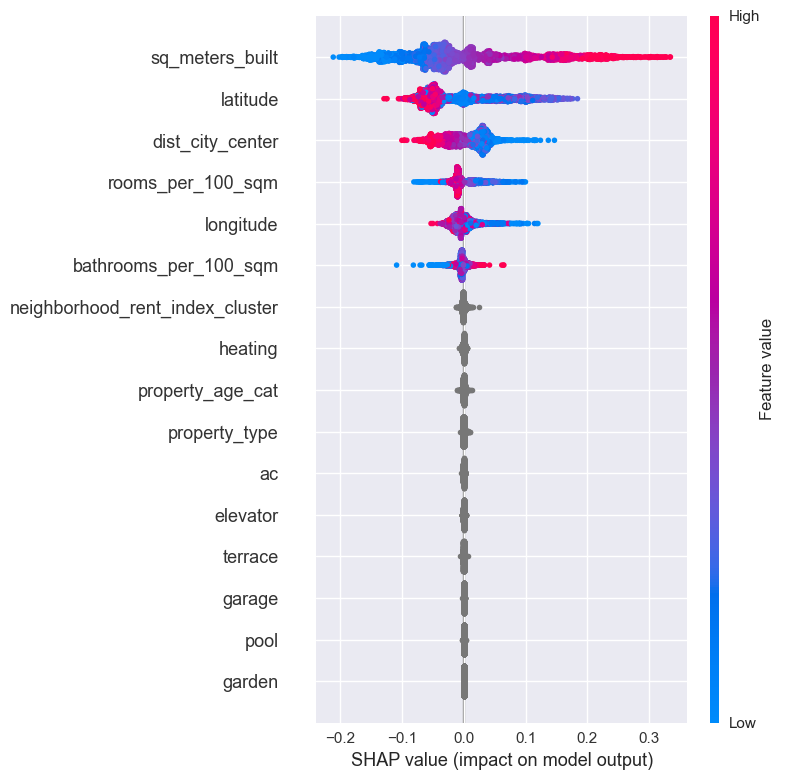

In [ ]:
shap.summary_plot(shap_values_cat2, X_train)

**Importancia total de los SHAP values:**
- Los metros cuadrados construidos es la más importante. 
    - Nuestro modelo funciona bien para las viviendas que no son extremadamente caras. En el histograma ya vimos que la mayoría de viviendas estaban en la parte izquierda del gráfico, y había unas pocas muy caras (con una cantidad de metros cuadrados construidos muy grande).
    - En la parte azul tenemos más información. 

- La distancia al centro de la ciudad nos dice que, como más cerca del centro, más cara es la vivienda. 
    - Todo lo que está a la derecha del eje quiere decir que el precio aumenta, y a la izquierda significa que el precio disminuye. 
    - A la derecha están los puntos azules: los valores bajos de distancia al centro. Por tanto, si vives en el centro, la vivienda será más cara que si vives lejos del centro. Hay mucha concentración de vivienda cerca del centro de la ciudad de BCN. 
 
- En gris son las variables categóricas. Por tanto, este gráfico no nos aporta mucho valor para variables categóricas. 

Los siguientes gráficos están ordenados por importancia de variables: 

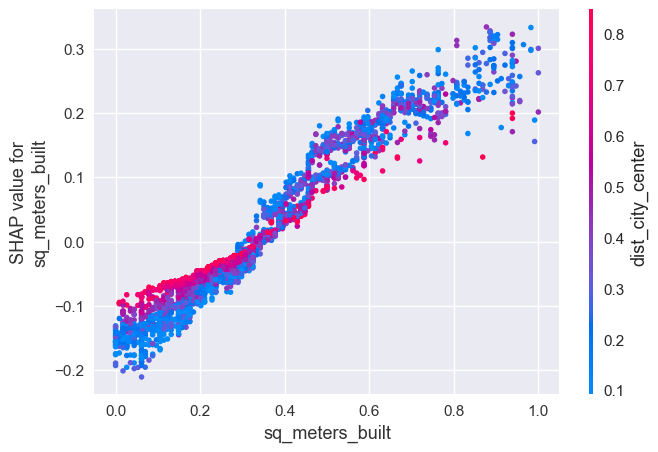

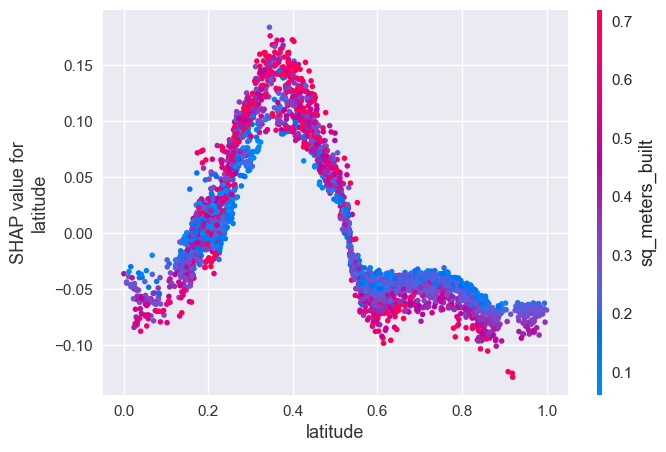

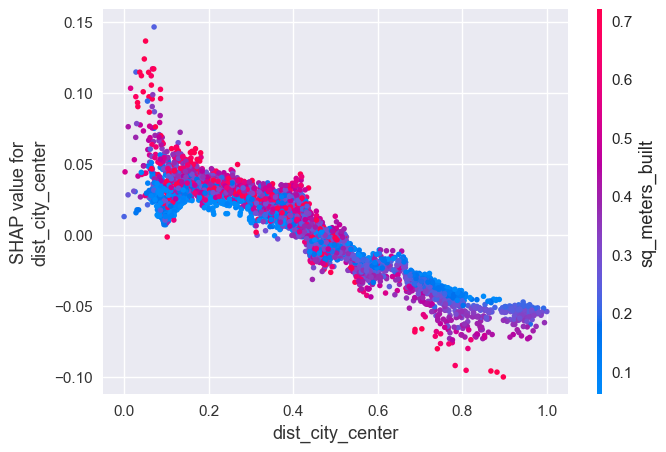

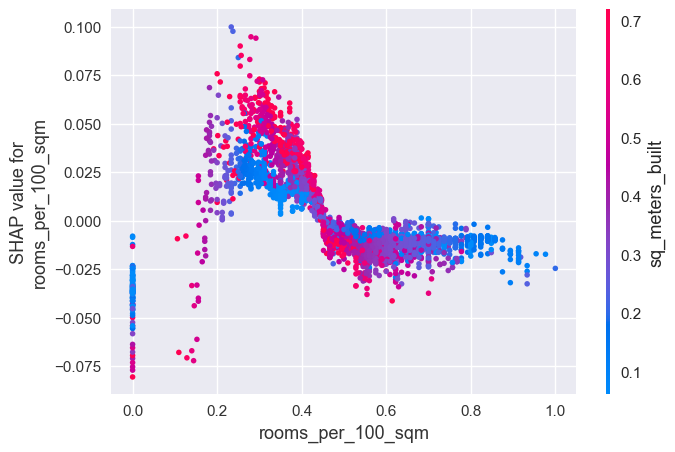

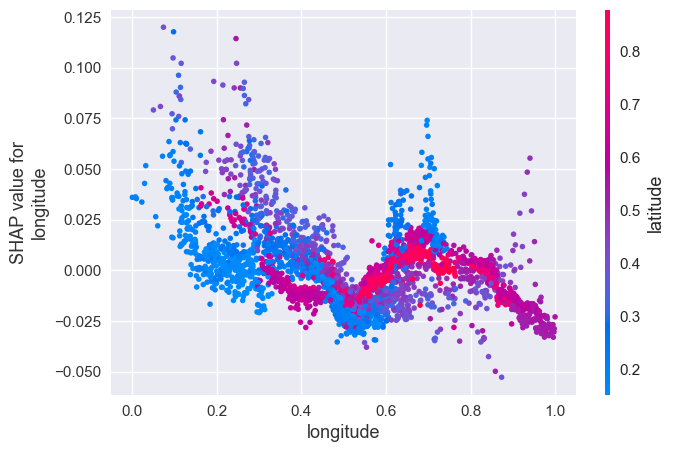

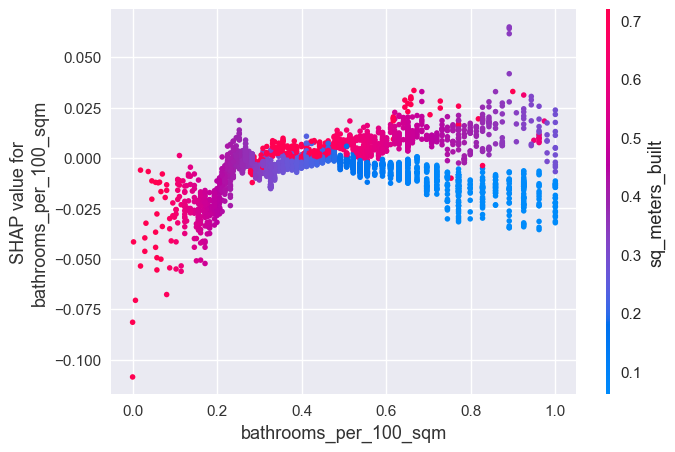

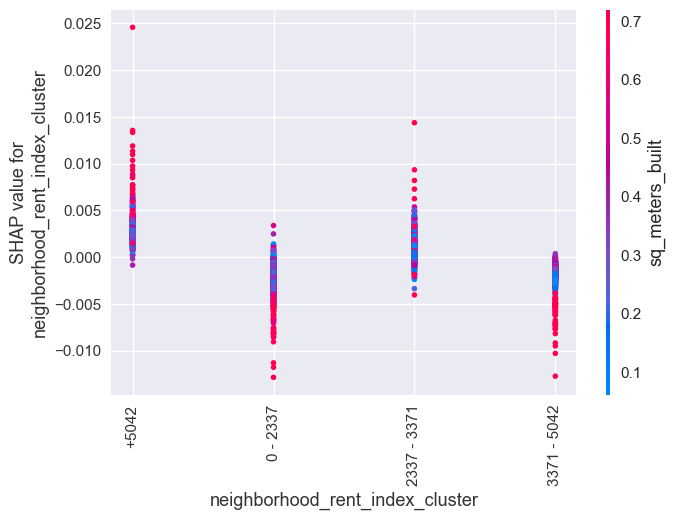

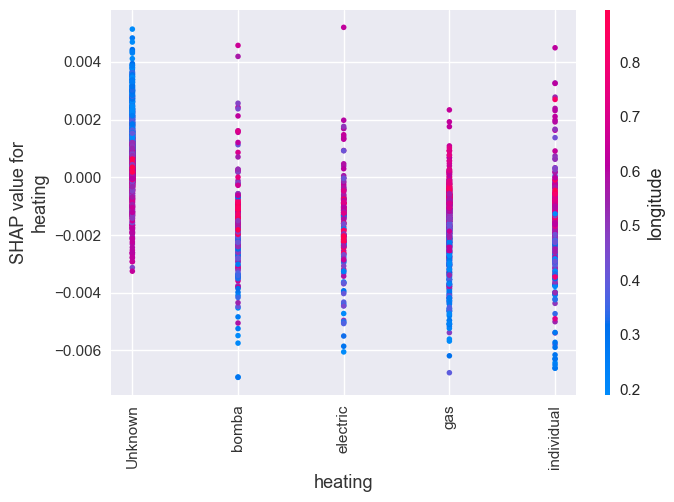

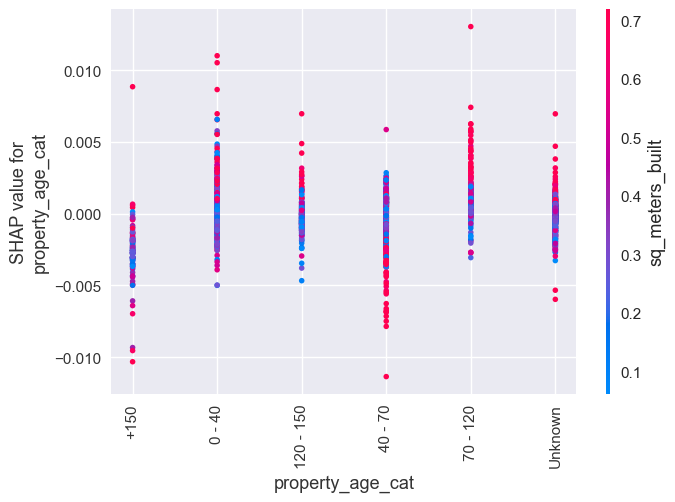

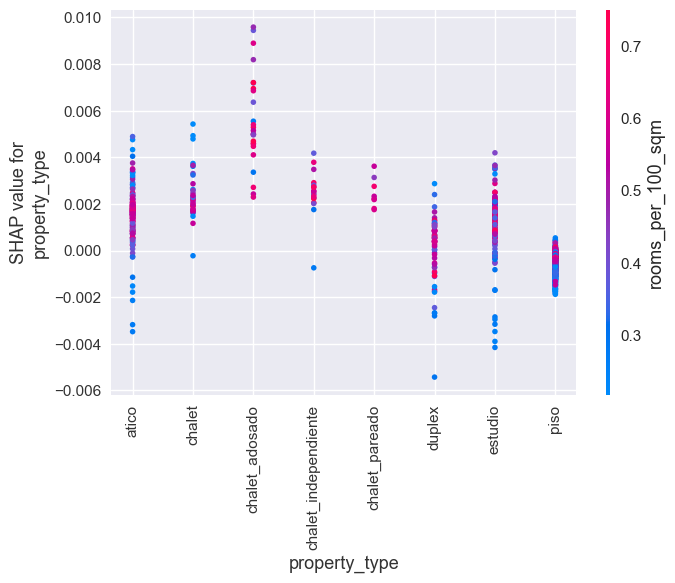

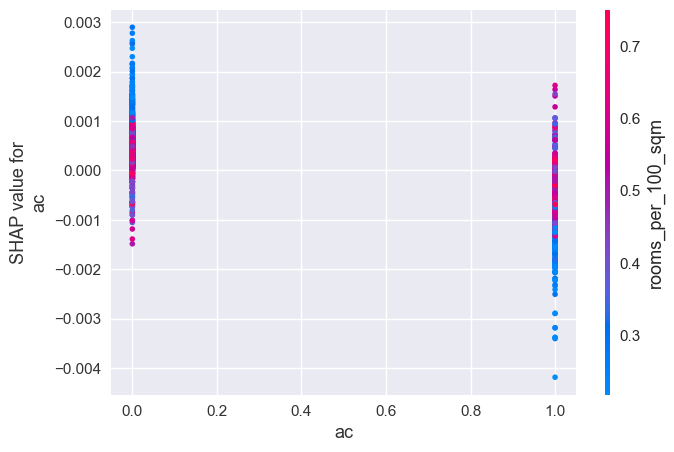

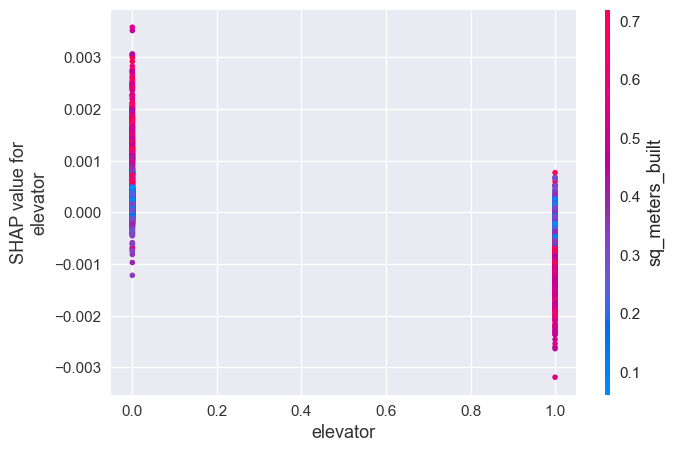

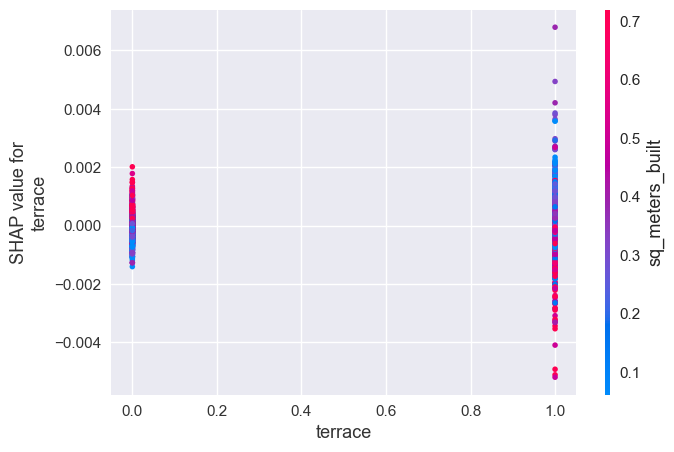

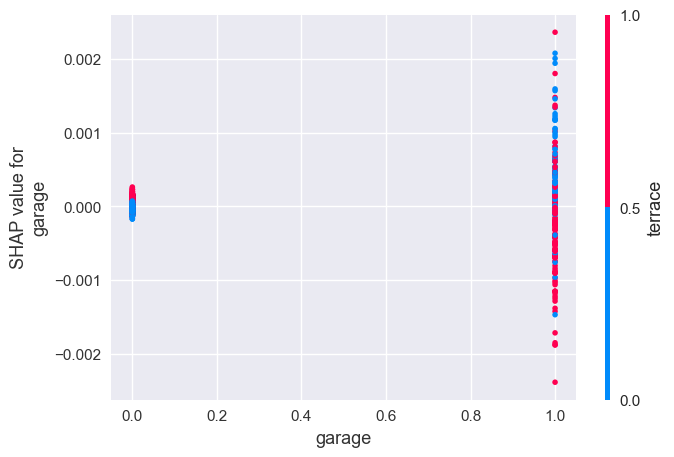

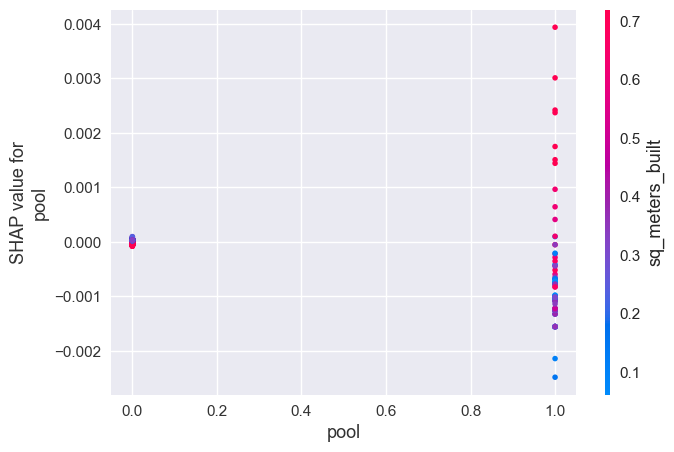

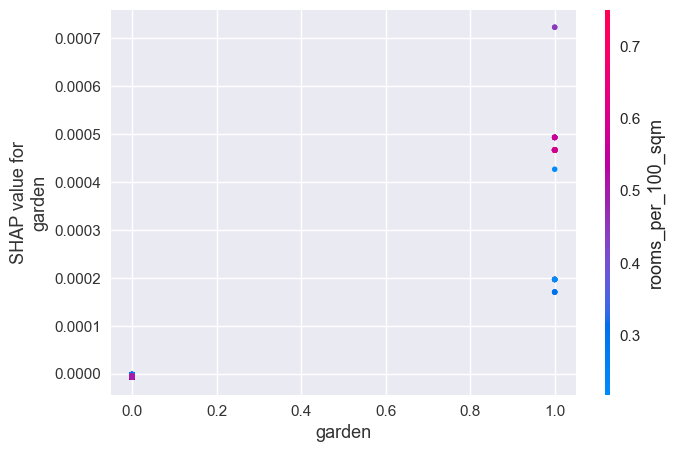

In [ ]:
top_inds = np.argsort(-np.sum(np.abs(shap_values_cat2), 0))

for i in range(0,len(top_inds)):
    shap.dependence_plot(top_inds[i], shap_values_cat2, X_train)

### Comparación de modelos:

In [ ]:
# Models results
display(models_results_df.sort_values('test_r2_score', ascending=False))

,regressor,train_r2_score,test_r2_score
6,BaggingRegressor_4,0.982617,0.856217
4,BaggingRegressor_3,0.982274,0.852508
7,RandomForestRegressor_4,0.947275,0.846601
5,RandomForestRegressor_3,0.946943,0.845112
9,CatBoostRegressor2,0.904457,0.837922
0,BaggingRegressor_1,0.976685,0.739290
1,RandomForestRegressor_1,0.939248,0.723103
2,BaggingRegressor_2,0.970111,0.690796
8,CatBoostRegressor_1,0.990734,0.683262
3,RandomForestRegressor_2,0.924524,0.674443


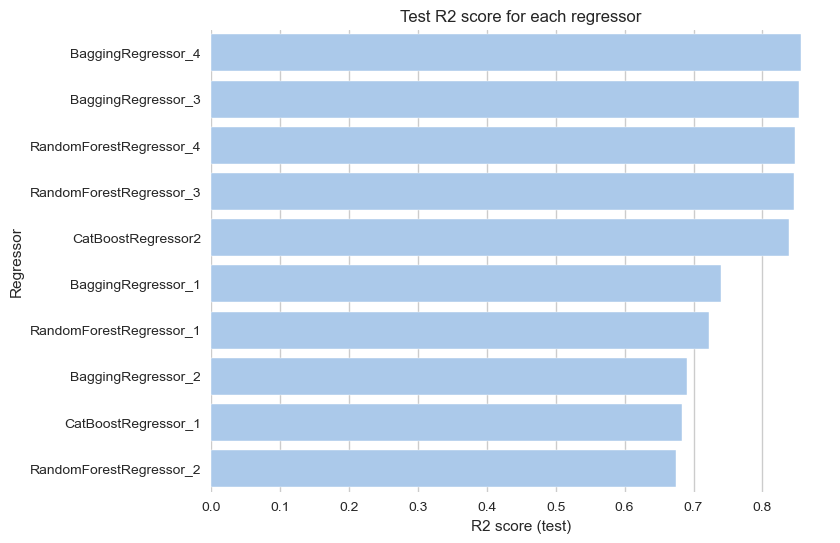

In [ ]:
# horizontal bar chart
sns.set_style('whitegrid')
sns.set_color_codes('pastel')
plt.figure(figsize=(8, 6))
ax = sns.barplot(x='test_r2_score', 
                 y='regressor', 
                 data=models_results_df.sort_values('test_r2_score', ascending=False), 
                 color='b')
sns.despine(left=True, bottom=True)
plt.title('Test R2 score for each regressor')
plt.xlabel('R2 score (test)')
plt.ylabel('Regressor')
plt.show()

Para predecir el precio de las casas de Barcelona, elegiría BaggingRegressor_4 o BaggingRegressor_3 porque tienen los valores test_r2_score más altos (0.856 y 0.852, respectivamente). Esto indica que estos modelos han funcionado bien durante las fases de entrenamiento y validación, y es probable que tengan un buen poder predictivo para datos nuevos no vistos.

Aunque CatBoostRegressor_1 tiene el valor train_r2_score más alto (0.99), su puntuación test_r2_score (0.68) es relativamente más baja en comparación con los modelos BaggingRegressor_3 y BaggingRegressor_4. Puede ser que se esté  sobreajustando a los datos de entrenamiento (overfitting) y, por tanto, no funciona tan bien con datos nuevos no vistos. Por otro lado, CatBoostRegressor_2 tiene un valor train_r2_score más bajo (0.90) y una puntuación test_r2_score relativamente alta (0.83), lo que indica que el modelo ha generalizado relativamente bien a los nuevos datos.


